In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

In [ ]:
# === Dataset Loading ===

transform = transforms.ToTensor() # Used to convert images into matrices/tensors

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True) # Batch is the data size the CNN is trained on before weight updating, shuffle is set to True so the model does not learn the order of the data and generalizes better

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False) 

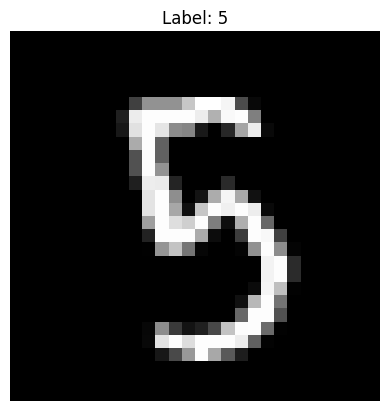

In [20]:
# === Random Image Plot ===
image, label = random.choice(trainset)
plt.imshow(image[0], cmap='gray') 
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [4]:
# === Model ===
class CustomCNN(nn.Module):
    def __init__(self): # __init__ is a function that defines the layers (building blocks) of the model
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # 1 input channel because black/white image
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2) # First 2 represents the window size i.e. 2x2, Second 2 represents how far the window moves

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.dropout_fc = nn.Dropout(0.3) # Randomly drops 30% of neurons during training to reduce overfitting
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x): # forward is a function that defines how data flows through those layers (the order of operations)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

In [5]:
# === Train ===
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = CustomCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10): # Train for 10 epochs to improve model performance
    for images, labels in trainloader: # Grabbing both the batch of image tensors and their labels
        images, labels = images.to(device), labels.to(device)
        outputs = model(images) # Model makes predictions for the batch
        loss = loss_fn(outputs, labels) # Compare predictions to actual labels to calculate loss
        optimizer.zero_grad()
        loss.backward() # Backpropagation
        optimizer.step() # Updates the models weights 

In [22]:
# === Evaluate ===
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 99.30%
